<a href="https://colab.research.google.com/github/cjfghk5697/Practice_Pytorch/blob/main/Practice_pytorch6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([ #train데이터
        transforms.RandomResizedCrop(224), #원래 224보다 큰 이미지 그래서 224사이즈로 맞춤
        transforms.RandomHorizontalFlip(), #좌우반전
        transforms.ToTensor(), #tensor로 바꿈
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #정규화
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224), #좌우 반전하지 않은 이미지
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/hymenoptera_data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4) #train, test
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


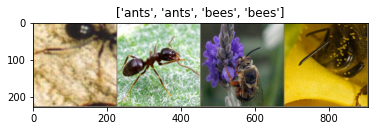

In [7]:
def imshow(inp, title=None): #이미지 보여주는 함수
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) #위에 nomalization 하는 과정
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated, 업데이트


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25): #모델, 척도, 기울기, 궤적, 몇번할지
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode 학습
            else:
                model.eval()   # Set model to evaluate mode 평가

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]: 
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad() #0인 상태로 만듦

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'): 
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase] #척도, 단위 x, 잘학습되었는지, 줄어든게 중요할뿐 단위는 중요 x
            epoch_acc = running_corrects.double() / dataset_sizes[phase] #단위 o

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) #내용물 전체 copy

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model 

In [9]:
def visualize_model(model, num_images=6): #시각화 6개 이미지씩
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j]) #눈으로 확인

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
model_ft = models.resnet18(pretrained=True) #레이어가 18개 있음, fine-tuning
num_ftrs = model_ft.fc.in_features #학습된 파라미터를 가져옴
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_ft.fc = nn.Linear(num_ftrs, 2) #벌, 개미 2개 object를 하기때문에 2개로 바꿈.

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.6301 Acc: 0.6926
val Loss: 0.2115 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.4552 Acc: 0.8320
val Loss: 0.2637 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.5265 Acc: 0.8074
val Loss: 0.3005 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.5953 Acc: 0.7664
val Loss: 0.3089 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.5601 Acc: 0.7705
val Loss: 0.2604 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.3687 Acc: 0.8566
val Loss: 0.2157 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.5449 Acc: 0.8033
val Loss: 0.2632 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3721 Acc: 0.8402
val Loss: 0.2421 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3327 Acc: 0.8484
val Loss: 0.2472 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.3474 Acc: 0.8525
val Loss: 0.2382 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3881 Acc: 0.8074
val Loss: 0.2438 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.2483 Acc: 0.8934
val Loss: 0.2414 Acc: 0.9281

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


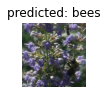

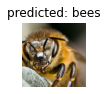

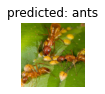

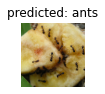

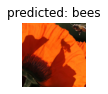

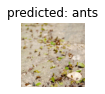

In [12]:
visualize_model(model_ft)


In [13]:
model_conv = torchvision.models.resnet18(pretrained=True) #재학습
for param in model_conv.parameters(): #다른점 하나
    param.requires_grad = False #우리는 기존에 있는 거 그대로 쓰고 마지막 fc만 업데이트 할 거다.

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [14]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.8103 Acc: 0.5984
val Loss: 0.3539 Acc: 0.8366

Epoch 1/24
----------
train Loss: 0.4346 Acc: 0.7787
val Loss: 0.4684 Acc: 0.8105

Epoch 2/24
----------
train Loss: 0.5204 Acc: 0.7828
val Loss: 0.2040 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.4433 Acc: 0.8156
val Loss: 0.2031 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4546 Acc: 0.8033
val Loss: 0.1932 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.5584 Acc: 0.7295
val Loss: 0.1737 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.5125 Acc: 0.7869
val Loss: 0.1955 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.3286 Acc: 0.8689
val Loss: 0.2074 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3603 Acc: 0.8361
val Loss: 0.1923 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.4487 Acc: 0.7992
val Loss: 0.2330 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3529 Acc: 0.8443
val Loss: 0.1643 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3488 Acc: 0.8238
val Loss: 0.1965 Acc: 0.9412

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


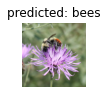

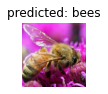

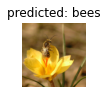

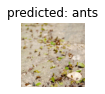

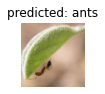

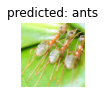

In [15]:
visualize_model(model_conv)

plt.ioff()
plt.show()